# Twitter Sentiment Analysis

## Notebook 3 : Deep Learning comparison of model ANN, LSTM and BERT

In [ ]:
# new library download

# !pip install torch==2.0.0 --quiet
# !pip install pytorch_lightning==2.2.0 --quiet
# !pip install torchtext==0.15.1 --quiet
# !pip install mlflow==2.9.0 --quiet
# !pip install gensim==4.3.0 --quiet

!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Importing libraires for file and time operations
import os
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module="mlflow")

# Libraries for random number generation
import random


# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


from itertools import product

# library for experiment tracking
import mlflow

# Library for splitting data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# libraries for Word2Vec
# import gensim
from gensim.models import Word2Vec

# libraries for nltk
# import nltk
from nltk import tokenize
from nltk.tokenize import WhitespaceTokenizer

# Libraries for Deep Learning with PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


# Libraries for model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Library for clearing Jupyter Notebook cell output
from IPython.display import clear_output

## Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy files from google drive to google colab content

# !cp '/content/drive/MyDrive/Twitter_Sentiment_Analysis_1/training_processed_data.csv' '/content/'
# !cp '/content/drive/MyDrive/Twitter_Sentiment_Analysis_1/SKIP_Word2Vec.model' '/content/'
# !cp '/content/drive/MyDrive/Twitter_Sentiment_Analysis_2/CBOW_Word2Vec.model' '/content/'

In [ ]:
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis_21_02/CBOW_Word2Vec.model" "/content"
!cp "/content/drive/MyDrive/Twitter_Sentiment_Analysis_21_02/training_processed_data_final_notebook1.csv" "/content/"

In [ ]:
# Load the dataset

dataset_1 = pd.read_csv('training_processed_data_final_notebook1.csv')
dataset = dataset_1.sample(500000)
dataset.sample(5)

,target,text
179669,0,try mechduel login work
742421,0,manage unfollow block ppl block not disappear
1072188,1,yay check music demand everyday check today go...
416892,0,yeah salt water pool think lost cause
1464699,1,fun miley let know like film song


In [ ]:
dataset.target.value_counts()

,count
target,
1,100313
0,99687


In [ ]:
dataset.dropna(axis = 0, how = "any", inplace = True)
dataset.isnull().sum()

,0
target,0
text,0


In [ ]:
dataset.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 495382 to 1463466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   text    200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 20.7 MB


In [ ]:
dataset['target'].value_counts()

,count
target,
1,100313
0,99687


## Load Pretrained Models

In [ ]:
# Define the path to the pre-trained Word2Vec models
cbow_path = '/content/CBOW_Word2Vec.model'
# sg_path = '/content/SKIP_Word2Vec.model'

# Load the models in the memory
cbow = Word2Vec.load(cbow_path)
# sg = Word2Vec.load(sg_path)

## Setting the seed for reproducibility

In [ ]:
def set_seed(seed_value):
  # set python's random seed
  random.seed(seed_value)

  # set numpy's random seed
  np.random.seed(seed_value)

  os.environ['PYTHONHASHSEED'] = str(seed_value)
  # set Pytorch;s CPU seed
  torch.manual_seed(seed_value)
  # Set CuDNN deterministic mode (for further reproducibility)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  # Set generator for torch
  generator = torch.Generator().manual_seed(seed_value)
  # Set PyTorch's GPU seed (if available)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

## Setting up the computational Device

In [ ]:
# Choose GPU if available, otherwise use CPU and print the device being used
if torch.cuda.is_available():
    device = torch.device("cuda")     # Use GPU
    print(f'There are {torch.cuda.device_count()} GPUs available.')
    print(f"Device select for training : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")      # Use CPU
    print("No GPU available, using the CPU instead.")

No GPU available, using the CPU instead.


## Make Custom Pytorch Dataset

In [ ]:
# import library

# from torchtext.data.utils import get_tokenizer

# initiate the torctext tokenizer
tokenizer = WhitespaceTokenizer()

In [ ]:
# make a custom pytorch dataset
class TwitterDataset(Dataset):
  def __init__(self, df,word2vec_model, is_test = False):
    self.df = df
    self.is_test = is_test
    self.word2vec_model = word2vec_model

  def __getitem__(self, index):
    tweet_text = self.df.iloc[index]['text']
    tweet_tokens = tokenizer.tokenize(tweet_text)

    word_vectors =[self.word2vec_model.wv[word] for word in tweet_tokens if word in self.word2vec_model.wv]

    if len(word_vectors) == 0:
      input = torch.zeros(200)
    else:
      input = torch.tensor(np.mean(word_vectors, axis =0), dtype = torch.float32)


    # if self.is_test:
    #   target = torch.tensor([0], dtype = torch.float32)
    # else:
    target = torch.tensor([self.df.iloc[index]['target']], dtype = torch.float32)

    return input, target

  def __len__(self):
    return len(self.df)

In [ ]:
#Experiment


temp_1 = dataset[:5]

temp_2 = TwitterDataset(temp_1, word2vec_model = cbow,is_test = False)
print(temp_2[3])

(tensor([ 0.1510,  0.2706, -0.3286, -0.7194, -0.1016,  0.1943,  1.1487,  0.2002,
        -0.1133,  0.3143, -0.2446,  0.3675, -0.1181, -0.1555,  0.1643,  0.5242,
        -0.0223, -0.3667, -0.1079, -0.5060, -0.2498, -0.8101,  0.4925, -0.1537,
        -0.1921,  0.0192,  0.2448, -0.4701, -0.5714, -0.1860, -0.1345, -0.0324,
         0.1451,  0.0474, -0.3891, -0.2404,  0.5103,  0.4034, -0.0331, -0.0614,
         0.1175,  0.4099, -0.1469,  0.3396,  0.0602, -0.0482,  0.1601, -0.2641,
         0.2016,  0.0584, -0.4639, -0.0509,  0.8684, -0.3144,  0.3643, -0.5611,
         0.8167, -0.1006, -0.6634,  0.4602,  0.8861, -0.4066,  0.9251,  0.5964,
         0.3996,  0.4635,  0.4551, -0.4037, -0.0280, -0.2076, -0.3669, -0.4207,
         0.3066,  0.0619, -0.3195, -0.5156, -0.2353, -0.1007, -1.0384, -0.4465,
        -0.2622, -0.0974, -0.0077, -0.8847, -0.4561,  0.1720,  0.2126, -0.6543,
        -0.3456, -0.2588,  0.3787, -0.3825,  0.4006,  0.5429,  0.0013, -0.1688,
        -0.4389,  0.1415, -0.3408, -0.3

## Splitting the data into Train and Test data

In [ ]:
# import random split from pytorch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# Length of the split
TRAIN_SIZE = int(0.7*len(dataset))
VAL_SIZE = int(0.2*len(dataset))
TEST_SIZE = len(dataset)-TRAIN_SIZE-VAL_SIZE

print(TRAIN_SIZE,VAL_SIZE,TEST_SIZE)

140000 40000 20000


In [ ]:
# Step 1: Split into train and temp (val + test)
train_dataset_split, temp_df = train_test_split(dataset, test_size=(VAL_SIZE + TEST_SIZE), random_state=42, shuffle=True)

# Step 2: Split temp into validation and test
val_dataset_split, test_dataset_split = train_test_split(temp_df, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42, shuffle=True)

# split the dataset into train, validation and testing data
print(len(train_dataset_split), len(val_dataset_split),len(test_dataset_split))

140000 40000 20000


In [ ]:
# Pytorch Dataset instances
train_dataset = TwitterDataset(train_dataset_split, word2vec_model = cbow, is_test = False)
val_dataset = TwitterDataset(val_dataset_split, word2vec_model = cbow, is_test = True)
test_dataset = TwitterDataset(test_dataset_split, word2vec_model = cbow, is_test = True)

In [ ]:
# BATCH_SIZE
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size  = BATCH_SIZE,  num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size  = BATCH_SIZE,  num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size  = BATCH_SIZE,  num_workers = 2)

In [ ]:
# Experiment
for inputs, targets in train_loader:
  print(f"size of input {inputs.shape} and target is {targets.shape}")
  break

for inputs, targets in val_loader:
  print(f"size of input {inputs.shape} and target is {targets.shape}")
  break

for inputs, targets in test_loader:
  print(f"size of input {inputs.shape} and target is {targets.shape}")
  break

size of input torch.Size([64, 200]) and target is torch.Size([64, 1])
size of input torch.Size([64, 200]) and target is torch.Size([64, 1])
size of input torch.Size([64, 200]) and target is torch.Size([64, 1])


## Build Nerual Network

In [ ]:
from tqdm import tnrange,tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

class Classifier(nn.Module):
    def __init__(self, input_size = 200, hidden_size_1=128, hidden_size_2 = 64, out_size=1, dropout_prob=0.3):
        super(Classifier, self).__init__()

        self.features = nn.Sequential(

            # Hidden Layer 1
            nn.Linear(input_size, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            # Hidden Layer 2
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Ouptut Layer
        self.out = nn.Linear(hidden_size_2, out_size)

    def forward(self, X):
        feature = self.features(X)
        output = self.out(feature)
        return output

In [ ]:
def train(train_loader, net, epoch, criterion, optimizer):

  # set the network to training mode
  net.train()

  # Initialize list to store batch loss
  epoch_loss = []

  # Iterate through each batch in the training data loader
  for batch_idx, batch in enumerate(tqdm(train_loader)):
    data, target = batch
    # print(f"Before transfer: data={data.device}, target={target.device}")  # Debugging line

    # Move the data and labels to the chosen device
    data , target = data.to(device,non_blocking=True), target.to(device,non_blocking=True)
    # print(f"After transfer: data={data.device}, target={target.device}")  # Debugging line

    # Forward pass: commute predictions and loss
    pred = net(data)
    loss = criterion(pred,target.float())
    epoch_loss.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Convert epoch loss to numpy array and compute mean
  epoch_loss = np.array(epoch_loss)
  epoch_loss_avg = epoch_loss.mean()

  print(f"Epoch {epoch}: Average train Loss: {epoch_loss_avg:.4f}")

  return epoch_loss_avg

In [ ]:
def test(test_loader, net, epoch, criterion):
  # set the network for evaluation mode
  net.eval()

  # Disable gradient calculation for performance calculation
  with torch.no_grad():
    # Initiate loss list to store the loss
    epoch_val_loss = []

    # Iterate through each batch in the test data loader
    for batch_idx, batch in enumerate(tqdm(val_loader)):
      data,target = batch

      # Move data and target to the chosen device
      data, target = data.to(device), target.to(device)

      # Forward pass: compute predictoins and loss
      pred = net(data)
      loss = criterion(pred, target.float())
      epoch_val_loss.append(loss.item())

    #Convcer the epoch loss to numpy array and compute the mean
    epoch_val_loss = np.asarray(epoch_val_loss)
    epoch_val_loss_avg = epoch_val_loss.mean()

    print(f"Epoch {epoch}: Average test Loss: {epoch_val_loss_avg:.4f}")

    return epoch_val_loss_avg

In [ ]:
# Main function to train the neural network
def train_nn( args, hidden_size_1 = 128, hidden_size_2 = 64, input_size = 200, output_size = 1):

    # Start MLflow run for experiment tracking
    with mlflow.start_run(experiment_id=experiment_id):
        # Log hyperparameters
        for key, value in args.items():
            mlflow.log_param(key, value)

        # Log neural network architecture details
        mlflow.log_param('input_size', input_size)
        mlflow.log_param('hidden_size_1', hidden_size_1)
        mlflow.log_param('hidden_size_2', hidden_size_2)
        mlflow.log_param('output_size', output_size)

        # net = Classifier(input_size,hidden_size_1, output_size)
        net = Classifier()
        net.to(device)

        # Defines the loss function
        criterion = nn.BCEWithLogitsLoss()

        optimizer = optim.AdamW(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

        # Initializes variables to keep track of losses and other metrics
        train_losses, test_losses = [], []
        best_test_loss = float('inf')
        best_model_epoch = -1
        no_improvement_epochs = 0

        # Records the time at which training starts
        start_time = time.time()

        # Main training loop
        for epoch in range(args['num_epochs']):
            # Clears the output and prints the current training status
            # clear_output(wait=True)

            print('Training neural network... Epoch ' + str(epoch) + '/' + str(args['num_epochs']-1))
            if best_model_epoch!=-1:
                print("Best test loss epoch: " + str(best_model_epoch))

            # Trains the network and logs the loss
            epoch_train_loss = train(train_loader, net, epoch,criterion, optimizer)
            train_losses.append(epoch_train_loss)
            mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)

            # Tests the network and logs the loss
            epoch_test_loss = test(test_loader, net, epoch, criterion)
            test_losses.append(epoch_test_loss)


            # Checks for improvements in test loss
            dif = best_test_loss - epoch_test_loss
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                # Save the state of the best model for future reference
                torch.save(net.state_dict(), 'backup_best_model.pth')
                mlflow.log_metric("best_test_loss_so_far", best_test_loss, step=epoch)
                best_model_epoch = epoch

            # Implements early stopping based on a predefined tolerance and patience
            if dif > args['tolerance']:
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
            if no_improvement_epochs >= args['patience']:
                print("Early stopping at epoch: ", epoch)
                break

        # Records the time at which training ends and calculates the duration
        end_time = time.time()
        duration = end_time - start_time

        # Clears the output and prints the final training status
        # clear_output(wait=True)
        print("Neural network training has finished. Elapsed Time: {:.2f} seconds.".format(duration))
        print("Best model saved.")
        print("Best test loss epoch: " + str(best_model_epoch))

        # Loads the best model
        true_test_labels, predicted_test_labels = [], []
        net.load_state_dict(torch.load("backup_best_model.pth"))

        # Uses the best model to make predictions on the test data
        with torch.no_grad():
          for batch in test_loader:
            dado, rotulo = batch
            dado, rotulo = dado.to(device), rotulo.to(device)
            pred = net(dado)
            true_test_labels.extend(rotulo.detach().cpu().numpy())
            predicted_test_labels.extend((torch.sigmoid(pred) > 0.5).detach().cpu().numpy())

          # Calculates performance metrics and logs them using MLflow
          test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
          test_precision = precision_score(true_test_labels, predicted_test_labels)
          test_recall = recall_score(true_test_labels, predicted_test_labels)
          test_f1 = f1_score(true_test_labels, predicted_test_labels)
          mlflow.pytorch.log_model(net, "models")
          mlflow.log_metric("test_accuracy", test_accuracy)
          mlflow.log_metric("test_precision", test_precision)
          mlflow.log_metric("test_recall", test_recall)
          mlflow.log_metric("test_f1", test_f1)
          mlflow.log_metric("duration", duration)

          # Prints the performance metrics of the best model
          print("Best model metrics:")
          print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(test_accuracy, test_precision, test_recall, test_f1))

    return(train_losses, test_losses, best_model_epoch)

In [ ]:
# Set experiment name for MLflow tracking
experiment_name = "BASIC_NN"

# Check if experiment exists; create it if not
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    # Get existing experiment ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorization': ['cbow'],
    'criterion': ['BCEWithLogitsLoss'],
    'optimizer': ['Adam'],
    'batch_size': [128],
    'num_workers': [8],
    'lr': [0.0001,0.0005,0.001],  #
    'weight_decay': [0.0005,0.0001, 0.001 ], #
    'num_epochs': [500],
    'tolerance': [0.0003],
    'patience': [5]
}

# Generate all combinations of hyperparameters for grid search
all_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

In [ ]:
# all_combinations

In [ ]:
# Function to remove already trained combinations from the list
def remove_trained(combinations, experiment_id):
    # Fetch all runs from MLflow for the given experiment ID
    runs = pd.DataFrame(mlflow.search_runs(experiment_id))

    trained_lst = []
    not_trained_lst = []

    # Loop through all runs to gather parameters of trained models
    for i in range(runs.shape[0]):
        run = runs.iloc[i]
        params = {
            'vectorization': run['params.vectorization'],
            'criterion': run['params.criterion'],
            'optimizer': run['params.optimizer'],
            'batch_size': int(run['params.batch_size']),
            'num_workers': int(run['params.num_workers']),
            'lr': float(run['params.lr']),
            # 'weight_decay': float(run['params.weight_decay']),
            'num_epochs': int(run['params.num_epochs']),
            'tolerance': float(run['params.tolerance']),
            'patience': int(run['params.patience'])
        }

        trained_lst.append(params)

    # Check which combinations are not yet trained
    for i in range(len(combinations)):
        already_trained = False

        for j in range(len(trained_lst)):
            if combinations[i] == trained_lst[j]:
                already_trained = True

        if not already_trained:
            not_trained_lst.append(combinations[i])

    return(not_trained_lst)

# Remove already trained combinations from the list
not_trained_lst = remove_trained(all_combinations,experiment_id)

# Check if any combinations are left to train
if len(not_trained_lst)>0:
    print('There are {} combinations left to train.'.format(len(not_trained_lst)))
else:
    print('All models have already been trained.')

There are 1 combinations left to train.


In [ ]:
# Initialize an empty list to store the results
results = []

# Record the start time for the training process
start_time = time.time()

# Loop through each combination of hyperparameters that have not yet been trained
for params in all_combinations:
  # Train the neural network with the given parameters
  # train_losses, test_losses, best_epoch = train_nn(params,hidden_size_1 = 128,hidden_size_2=64,input_size = 200, output_size = 1)
  train_losses, test_losses, best_epoch = train_nn(params)

  # Append the training results to the results list
  results.append({
      'params': params,
      'train_losses': train_losses,
      'test_losses': test_losses,
      'best_epoch': best_epoch
    })

# Record the end time and calculate the total duration
print("\n")
print(f"Models are trained on all the input parameters.......... Elapsed Time is {time.time()-start_time}")

Training neural network... Epoch 0/499


100%|██████████| 2188/2188 [00:44<00:00, 49.27it/s]


Epoch 0: Average train Loss: 0.5591


100%|██████████| 625/625 [00:11<00:00, 53.98it/s]


Epoch 0: Average test Loss: 0.5086
Training neural network... Epoch 1/499
Best test loss epoch: 0


100%|██████████| 2188/2188 [00:46<00:00, 46.92it/s]


Epoch 1: Average train Loss: 0.5207


100%|██████████| 625/625 [00:11<00:00, 52.53it/s]


Epoch 1: Average test Loss: 0.4986
Training neural network... Epoch 2/499
Best test loss epoch: 1


100%|██████████| 2188/2188 [00:44<00:00, 48.79it/s]


Epoch 2: Average train Loss: 0.5097


100%|██████████| 625/625 [00:11<00:00, 54.03it/s]


Epoch 2: Average test Loss: 0.4938
Training neural network... Epoch 3/499
Best test loss epoch: 2


100%|██████████| 2188/2188 [00:44<00:00, 49.15it/s]


Epoch 3: Average train Loss: 0.5050


100%|██████████| 625/625 [00:11<00:00, 54.37it/s]


Epoch 3: Average test Loss: 0.4918
Training neural network... Epoch 4/499
Best test loss epoch: 3


100%|██████████| 2188/2188 [00:44<00:00, 49.47it/s]


Epoch 4: Average train Loss: 0.5016


100%|██████████| 625/625 [00:10<00:00, 61.21it/s]


Epoch 4: Average test Loss: 0.4899
Training neural network... Epoch 5/499
Best test loss epoch: 4


100%|██████████| 2188/2188 [00:49<00:00, 44.54it/s]


Epoch 5: Average train Loss: 0.4982


100%|██████████| 625/625 [00:10<00:00, 58.21it/s]


Epoch 5: Average test Loss: 0.4884
Training neural network... Epoch 6/499
Best test loss epoch: 5


100%|██████████| 2188/2188 [00:46<00:00, 47.40it/s]


Epoch 6: Average train Loss: 0.4957


100%|██████████| 625/625 [00:10<00:00, 60.11it/s]

Epoch 6: Average test Loss: 0.4875
Early stopping at epoch:  6
Neural network training has finished. Elapsed Time: 397.93 seconds.
Best model saved.
Best test loss epoch: 6



<ipython-input-32-28b580c2e55c>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("backup_best_model.pth"))
2025/02/23 06:30:14 WARNING mlflo

Best model metrics:
Accuracy: 0.7630, Precision: 0.7692, Recall: 0.7569, F1: 0.7630


Models are trained on all the input parameters.......... Elapsed Time is 423.06715846061707


In [ ]:
!cp "/content/mlruns" -r "/content/drive/MyDrive/Twitter_Sentiment_Analysis_21_02/ANN"

In [ ]:
# Function to retrieve experiment data from MLflow and format it into a DataFrame
def retrieve_experiments(id):
    # Fetch all runs for the given experiment ID and convert it to a DataFrame
    df = pd.DataFrame(mlflow.search_runs(experiment_ids=[id]))

    # Select and rename the columns of interest
    df = df[['run_id', 'metrics.best_test_loss_so_far', 'metrics.test_accuracy','metrics.test_f1','metrics.test_recall', 'metrics.test_precision',
          'metrics.duration', 'params.vectorization', 'params.lr', 'params.tolerance', 'params.patience','params.weight_decay']]
    df = df.rename(columns={
        'run_id': 'Run ID', 'metrics.best_test_loss_so_far': 'Best Loss', 'metrics.test_accuracy': 'Accuracy', 'metrics.test_f1': 'F1',
        'metrics.test_recall': 'Recall', 'metrics.test_precision': 'Precision', 'metrics.duration': 'Duration', 'params.vectorization': 'Vectorization',
        'params.lr': 'LR', 'params.tolerance': 'Tolerance', 'params.patience': 'Patience', 'params.weight_decay': 'Weight Decay'})
    return df

# Retrieve and display the experiment data, sorted by 'Best Loss'


df_basic = retrieve_experiments(experiment_id)
display(df_basic.sort_values(by='Best Loss', ascending=True))

,Run ID,Best Loss,Accuracy,F1,Recall,Precision,Duration,Vectorization,LR,Tolerance,Patience,Weight Decay
0,0ca0907dec154b57bbcde4be43b8f3bd,0.487531,0.76295,0.762962,0.756869,0.769153,397.931942,cbow,0.0001,0.005,5,0.0005


In [ ]:
df_basic['Run ID'][0]

'd92ee578cd83469ab7175005f4de69a0'

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(f"MLflow experiment ID is {experiment_id}")

MLflow experiment ID is 235970565703592068


In [ ]:
# import mlflow
import mlflow.pytorch  # Use mlflow.tensorflow or mlflow.sklearn if needed
print(f"Best Model ID is {df_basic['Run ID'][0]}")

best_run_id = df_basic['Run ID'][0]
model_path = f"mlruns/{experiment_id}/{best_run_id}/artifacts/models"
model = mlflow.pytorch.load_model(model_path)
model.eval()  # Set model to evaluation mode

Best Model ID is d92ee578cd83469ab7175005f4de69a0


Classifier(
  (features): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
 # Loads the best model
true_test_labels, predicted_test_labels = [], []
# input_size = 200  # Adjust if necessary
# hidden_size_1 = 128  # Adjust if necessary
# output_size = 1   # Adjust if necessary
# net = Classifier()
model.to(device)

# .load_state_dict(torch.load("backup_best_model.pth"))

# Uses the best model to make predictions on the test data
with torch.no_grad():
  for batch in test_loader:
    dado, rotulo = batch
    dado, rotulo = dado.to(device), rotulo.to(device)
    pred = model(dado)
    true_test_labels.extend(rotulo.detach().cpu().numpy())
    predicted_test_labels.extend((torch.sigmoid(pred) > 0.5).detach().cpu().numpy())

# Calculates performance metrics and logs them using MLflow
test_accuracy = classification_report(true_test_labels, predicted_test_labels)
print(test_accuracy)

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      2479
         1.0       0.75      0.75      0.75      2522

    accuracy                           0.75      5001
   macro avg       0.75      0.75      0.75      5001
weighted avg       0.75      0.75      0.75      5001




Confusion Matrix:
          Negative  Positive
Negative      1859       620
Positive       626      1896


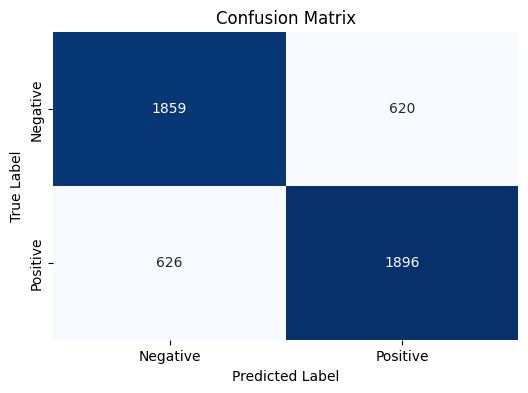

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_test_labels, predicted_test_labels)

labels = ["Negative", "Positive"]
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("\nConfusion Matrix:")
print(cm_df)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], cbar = False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

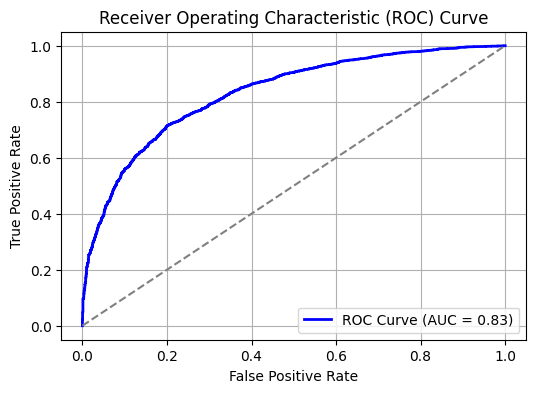

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure model is in evaluation mode
model.eval()

# Lists to store true labels and predicted probabilities
y_true = []
y_probs = []  # Probabilities instead of binary predictions

for inputs, labels in test_loader:  # Assuming test_loader is defined
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)  # Get probabilities from logits

    y_true.extend(labels.cpu().numpy())
    y_probs.extend(probs.cpu().numpy())

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC (Area Under the Curve)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()